# OpenCV Inpainting
OpenCV (Open Source Computer Vision Library) is an open-source computer vision and image processing library used for tasks like image manipulation, object detection, tracking, and computer vision modeling.
                                                                                                                
OpenCV inpainting is a technique that fills in damaged or missing regions in an image using information from surrounding pixels. It is rule-based and does not require training on datasets.

The method used in this notebook is Telea's Method, where:
- Marching method is used
- Missing areas are filled in by propagating pixel information inward from the boundary
- Pixels that are closest to known pixels are prioritized

In [6]:
# !pip install opencv-python scikit-image
# %pip install scikit-image

In [3]:
import os
os.getcwd()

'/mnt/processed/private/msds2025/cpt2/ML3/FinalProject/Inpainting'

### Evaluate PSNR and SSIM of OpenCV Inpainting
- Given test set, paintings without damage has been filtered out
- Telea method was used

In [9]:
import os
import cv2
import json
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# Paths relative to your notebook location
json_path = "testset_metadata.json"
gt_dir = "../data/img/full"
test_img_dir = "test/img"
mask_dir = "test/mask_backup"

# Open JSON metadata
with open(json_path, "r") as f:
    metadata = json.load(f)

# Filter out 'no damage' entries
damaged_entries = [entry for entry in metadata if entry['damage_type'].lower() != 'no']

# Results storage
psnr_scores = []
ssim_scores = []
results = []
skipped = []

for entry in tqdm(damaged_entries):
    image_id = entry["id"]
    damage_type = entry["damage_type"]

    # File paths
    gt_path_jpg = os.path.join(gt_dir, f"{image_id}.jpg")
    gt_path_png = os.path.join(gt_dir, f"{image_id}.png")
    damaged_path = os.path.join(test_img_dir, f"{image_id}.png")
    mask_path = os.path.join(mask_dir, f"{image_id}_mask.png")

    # Resolve GT path
    if os.path.exists(gt_path_jpg):
        gt_path = gt_path_jpg
    elif os.path.exists(gt_path_png):
        gt_path = gt_path_png
    else:
        skipped.append((image_id, "missing ground truth"))
        continue

    if not os.path.exists(damaged_path) or not os.path.exists(mask_path):
        skipped.append((image_id, "missing damaged image or mask"))
        continue

    # Load images
    gt_img = cv2.imread(gt_path)
    damaged_img = cv2.imread(damaged_path)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if any(x is None for x in [gt_img, damaged_img, mask_img]):
        skipped.append((image_id, "failed to load one or more images"))
        continue

    # Ensure sizes match
    if gt_img.shape != damaged_img.shape:
        damaged_img = cv2.resize(damaged_img, (gt_img.shape[1], gt_img.shape[0]))
        mask_img = cv2.resize(mask_img, (gt_img.shape[1], gt_img.shape[0]))

    # Apply OpenCV inpainting (Telea method)
    inpainted = cv2.inpaint(damaged_img, mask_img, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Convert to RGB for metric comparison
    gt_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)

    # Compute metrics
    psnr = psnr_metric(gt_rgb, inpainted_rgb, data_range=255)
    ssim = ssim_metric(gt_rgb, inpainted_rgb, multichannel=True, data_range=255, win_size=3)

    psnr_scores.append(psnr)
    ssim_scores.append(ssim)
    results.append({
        "id": image_id,
        "damage_type": damage_type,
        "psnr": psnr,
        "ssim": ssim
    })

# Summary
if psnr_scores:
    print(f"\nEvaluated {len(psnr_scores)} damaged images with OpenCV inpainting")
    print(f"Average PSNR: {sum(psnr_scores)/len(psnr_scores):.2f}")
    print(f"Average SSIM: {sum(ssim_scores)/len(ssim_scores):.4f}")
else:
    print("No images were successfully evaluated.")

# Save results (optional)
import pandas as pd
pd.DataFrame(results).to_csv("opencv_inpainting_eval.csv", index=False)
pd.DataFrame(skipped, columns=["id", "reason"]).to_csv("opencv_skipped.csv", index=False)


100%|██████████| 3934/3934 [23:39<00:00,  2.77it/s]



Evaluated 3934 damaged images with OpenCV inpainting
Average PSNR: 33.86
Average SSIM: 0.9677


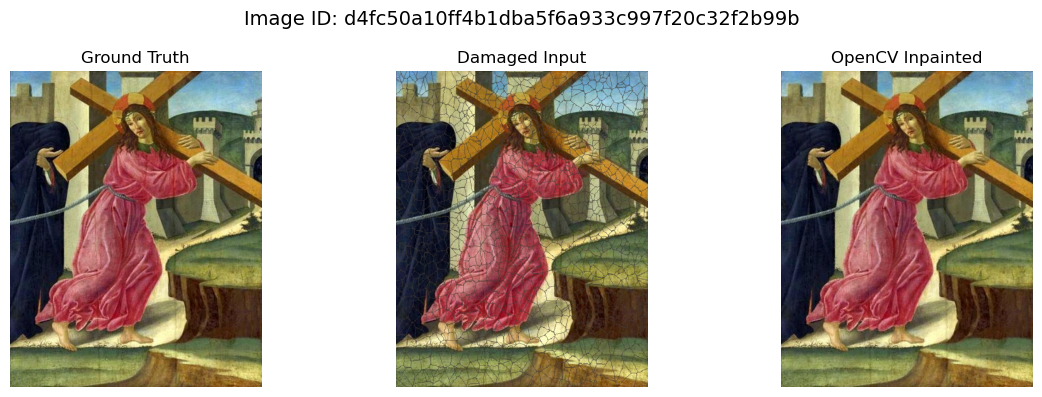

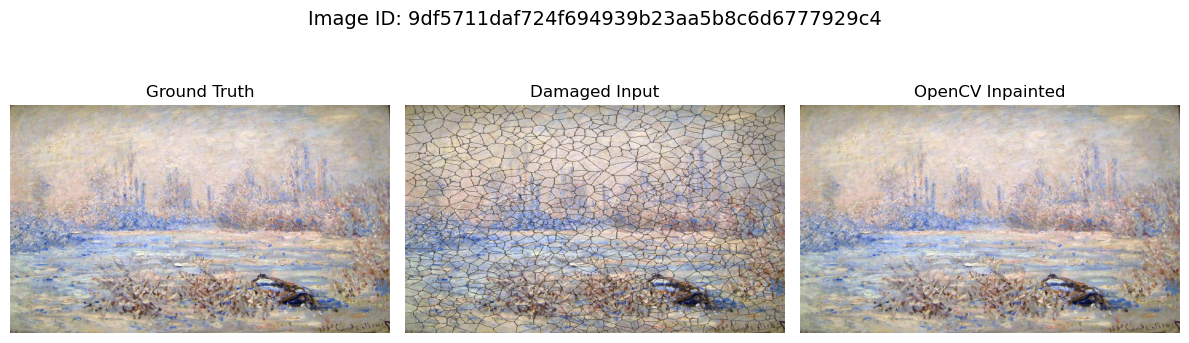

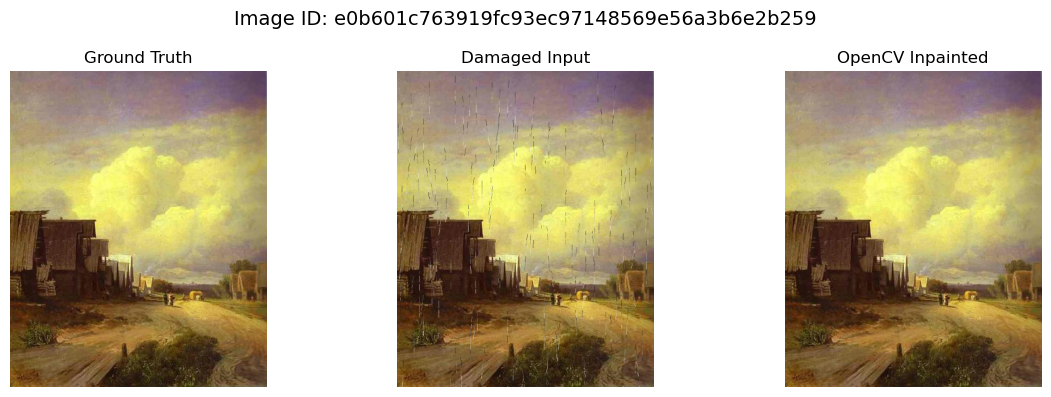

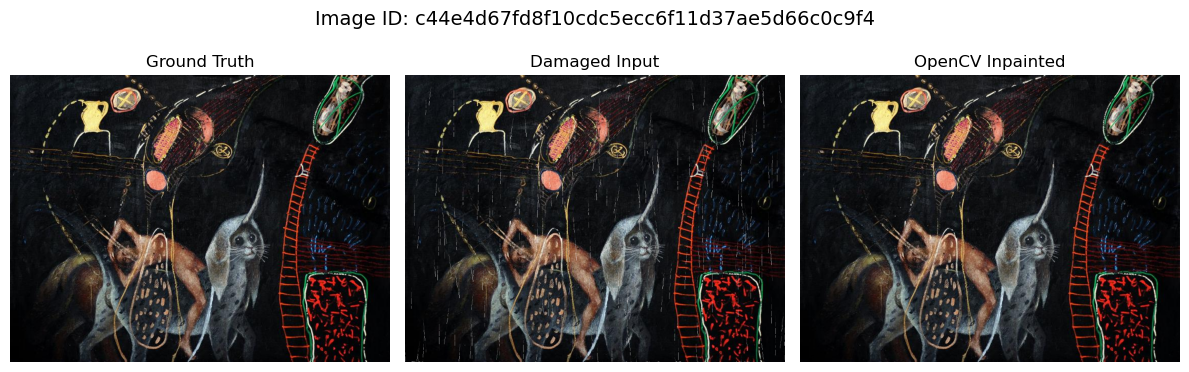

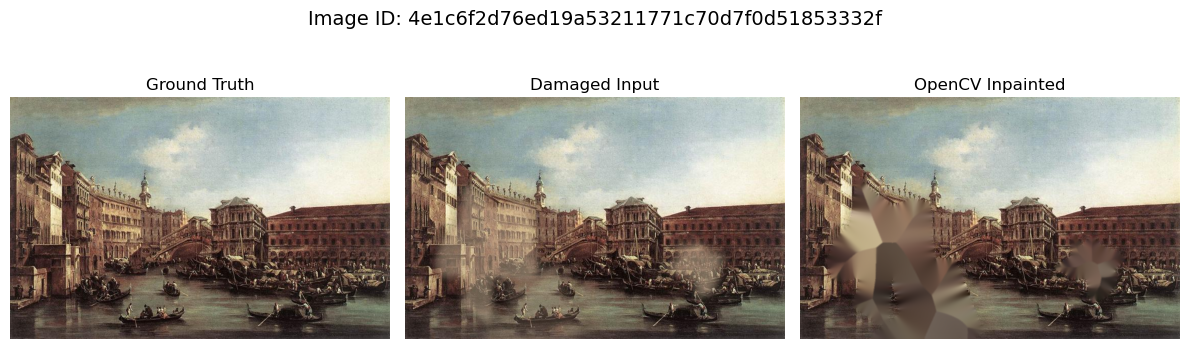

In [11]:
import matplotlib.pyplot as plt

# Show first 5 inpainted results with GT and Mask side-by-side
for entry in results[:5]:
    image_id = entry["id"]
    
    # Reconstruct paths
    gt_path_jpg = os.path.join(gt_dir, f"{image_id}.jpg")
    gt_path_png = os.path.join(gt_dir, f"{image_id}.png")
    damaged_path = os.path.join(test_img_dir, f"{image_id}.png")
    mask_path = os.path.join(mask_dir, f"{image_id}_mask.png")

    if os.path.exists(gt_path_jpg):
        gt_path = gt_path_jpg
    elif os.path.exists(gt_path_png):
        gt_path = gt_path_png
    else:
        continue

    gt_img = cv2.imread(gt_path)
    damaged_img = cv2.imread(damaged_path)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    inpainted = cv2.inpaint(damaged_img, mask_img, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Convert for display
    gt_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    damaged_rgb = cv2.cvtColor(damaged_img, cv2.COLOR_BGR2RGB)
    inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)

    # Plot all three
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Image ID: {image_id}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(gt_rgb)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(damaged_rgb)
    plt.title("Damaged Input")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(inpainted_rgb)
    plt.title("OpenCV Inpainted")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
